# A2: NeuralNetwork Class

In this assignment, you will implement a class named `NeuralNetwork` using code from lecture notes.  To do this, follow these steps.


1. Define the `__init__(self, n_inputs, n_hiddens_each_layer, n_outputs)` function with `n_inputs` as the number of input components in each sample (columns of `X`), `n_hiddens_each_layer` as the number of units in each hidden layer, and `n_outputs` as the number of outputs of the output layer. The length of `n_hiddens_each_layer` determines the number of hidden layers in the created neural network. The `__init__` functions must

    1. assign these values to member variables `self.n_inputs`, `self.n_hiddens_each_layer`, and `self.n_outputs`,
    1. initialize `self.rmse_trace` to an empty list,
    2. initialize `self.n_epochs` to 0,
    1. initialze `self.X_means` to `None` to indicate that `X` and `T` have not yet been standardized, and
    2. build in `self.Ws` a list of two-dimensional numpy arrays as weight matrices, one for each hidden layer, with uniformly distributed random values between -1 and 1 divided by the square root of the number of inputs to the corresponding layer. Append one more weight matrix of all zero values for the weight matrix in the output layer.

1. Define `__repr__(self)` and `__str__(self)` functions that return strings as shown in the examples in this notebook.

2. Define `_calc_rmse_standardized(self, Y, T` as shown in lecture notes.

1. Define the `_forward(self, X)` function that accepts `X` as standardized values, creates `self.Zs` as a list consisting of the input `X` and the outputs of each hidden layer and the output layer for all samples in `X` and returns the output of the network, `Y`, in standardized form.
  
1. Define  the `_gradients(self, X, T)` function that accepts `X` and `T` as standardized values and returns a list of numpy arrays containing the gradients of the mean square error with respect to the weights in each layer, in the order of the layers from the first hidden layer, second hidden layer, and so on,  to the output layer.
  
1. Define the `train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, learning_rate)` function that

    1. if `self.X_means` is `None`, standardizes `Xtrain` and `Ttrain` and saves the standardization parameters (means and stds) in member variables, `self.X_means`, `self.X_stds`, `self.T_means` and `self.T_stds`,
    1. standardizes `Xvalidate` and `Tvalidate` using `self.X_means`, `self.X_stds`, `self.T_means` and `self.T_stds`,
    1. loops for `n_epochs` as shown in notes `05` and for each loop,

        1. uses the `_forward` function to calculate the outputs of all units,
        1. uses the `_gradients` function to calculate the gradient of the the mean squared error respect to all weight matrices,
        1. updates all weight matrices using the gradients returned from `_gradients` using SGD, meaning the learning rate multiplied by the gradient,
        1. calculates the RMSE for train and validation data and appends a list of these two values to the list `self.rmse_trace`, and
    1. increments `self.n_epochs` by `n_epochs`.

1. Define `use(self, X)` that

    1. standardizes `X` using the standardization member variables,
    1. calls `_forward` to calculate the outputs of all units,
    1. unstandardizes the output of the network and returns it.

1. You may choose to define other functions, such as `_add_ones`, to be called by the functions above. Remember to name functions with a leading `_` that are not meant to be called by the users of your `NeuralNetwork` class.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd  # for display and clear_output
import time

In [2]:
class NeuralNetwork:
    def __init__(self, n_inputs, n_hiddens_each_layer, n_outputs):
        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hiddens_each_layer
        self.n_outputs = n_outputs
        self.rmse_trace = []
        self.n_epochs = 0
        self.X_means = None
        self.T_means = None
        self.X_stds = None
        self.T_stds = None

        # Initialize weights for each layer
        self.Ws = []
        layers = [n_inputs] + n_hiddens_each_layer + [n_outputs]
        for i in range(len(layers) - 1):
            if i < len(n_hiddens_each_layer):
                # Initialize weights with random values
                W = np.random.uniform(-1, 1, (layers[i] + 1, layers[i + 1])) / np.sqrt(layers[i])
            else:
                # Initialize output layer weights with small random values
                W = np.random.uniform(-0.1, 0.1, (layers[i] + 1, layers[i + 1]))
            self.Ws.append(W)

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_each_layer}, {self.n_outputs})'

    def __str__(self):
        return f'Neural Network: {self.n_inputs} inputs, {self.n_hiddens_each_layer} hidden layers, {self.n_outputs} outputs'

    def _calc_rmse_standardized(self, Y, T):
        return np.sqrt(np.mean((Y - T) ** 2))

    def _forward(self, X):
        Z = X
        self.Zs = [Z]
        for i, W in enumerate(self.Ws):
            Z = np.dot(np.c_[Z, np.ones((Z.shape[0], 1))], W)
            if i < len(self.Ws) - 1:
                Z = np.tanh(Z)  # Apply tanh activation for hidden layers
            self.Zs.append(Z)
        return Z

    def _gradients(self, X, T):
        gradients = []
        Y = self._forward(X)
        delta = (Y - T) / Y.shape[0]

        for i in range(len(self.Ws) - 1, -1, -1):
            Z = np.c_[self.Zs[i], np.ones((self.Zs[i].shape[0], 1))]
            gradients.insert(0, np.dot(Z.T, delta))

            if i > 0:  # Backpropagate through hidden layers
                delta = np.dot(delta, self.Ws[i].T)[:, :-1] * (1 - self.Zs[i] ** 2)  # Derivative of tanh

        return gradients

    def train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, learning_rate):
        if self.X_means is None:
            self.X_means = np.mean(Xtrain, axis=0)
            self.X_stds = np.std(Xtrain, axis=0)
            self.T_means = np.mean(Ttrain, axis=0)
            self.T_stds = np.std(Ttrain, axis=0)

        Xtrain = (Xtrain - self.X_means) / self.X_stds
        Ttrain = (Ttrain - self.T_means) / self.T_stds
        Xvalidate = (Xvalidate - self.X_means) / self.X_stds
        Tvalidate = (Tvalidate - self.T_means) / self.T_stds

        for epoch in range(n_epochs):
            Ytrain = self._forward(Xtrain)
            gradients = self._gradients(Xtrain, Ttrain)

            # Update weights
            for i in range(len(self.Ws)):
                self.Ws[i] -= learning_rate * gradients[i]

            # Calculate RMSE
            rmse_train = self._calc_rmse_standardized(Ytrain, Ttrain)
            Yvalidate = self._forward(Xvalidate)
            rmse_validate = self._calc_rmse_standardized(Yvalidate, Tvalidate)
            self.rmse_trace.append([rmse_train, rmse_validate])

        self.n_epochs += n_epochs

    def use(self, X):
        X = (X - self.X_means) / self.X_stds
        Y = self._forward(X)
        return Y * self.T_stds + self.T_means


In [3]:
# During development of your `NeuralNetwork` class, you may develop it in a python script file.
# Then, to test it you may import it by uncommenting the last line in this cell which assumes
# your python script is in `A2mysolution.py`.

# Before you check in your notebook, copy and paste the whole `NeuralNetwork` class definition into the
# above cell, and delete this cell.

# from A2solution import NeuralNetwork, create_model

In this next code cell, I add a new method to your class that replaces the weights created in your constructor with non-random values to allow you to compare your results with mine, and to allow our grading scripts to work well.

In [3]:
def set_weights_for_testing(self):
    # Set weights in hidden layers
    for W in self.Ws[:-1]:
        n_weights = W.shape[0] * W.shape[1]
        W[:] = np.linspace(-0.01, 0.01, n_weights).reshape(W.shape)
        for u in range(W.shape[1]):
            W[:, u] += (u - W.shape[1]/2) * 0.2

    # Set output layer weights to zero
    self.Ws[-1][:] = 0

    print('Weights set for testing by calling set_weights_for_testing()')

setattr(NeuralNetwork, 'set_weights_for_testing', set_weights_for_testing)

Now test your implementation, using example shown below and additional tests of your own creation.

## Example Results

Here we test your new `NeuralNetwork` class that allows 0, 1, 2, or more hidden layers with some simple data.  


In [4]:
X = np.arange(0, 10, 0.1).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)
X.shape, T.shape

((100, 1), (100, 1))

In [5]:
# Collect every 5th sample as the validation set.
validate_rows = np.arange(0, X.shape[0], 5)
# All remaining samples are in the train set.
train_rows = np.setdiff1d(np.arange(X.shape[0]), validate_rows)

Xtrain = X[train_rows, :]
Ttrain = T[train_rows, :]
Xvalidate = X[validate_rows, :]
Tvalidate = T[validate_rows, :]

print(f'{Xtrain.shape=} {Ttrain.shape=} {Xvalidate.shape=} {Tvalidate.shape=}')

Xtrain.shape=(80, 1) Ttrain.shape=(80, 1) Xvalidate.shape=(20, 1) Tvalidate.shape=(20, 1)


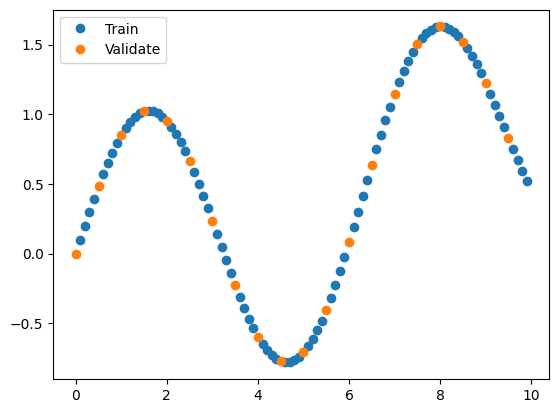

In [6]:
plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.plot(Xvalidate, Tvalidate, 'o', label='Validate')
plt.legend();

In [7]:
n_inputs = X.shape[1]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, [3, 2], n_outputs)
nnet  # using __repr__

NeuralNetwork(1, [3, 2], 1)

In [8]:
nnet.n_inputs, nnet.n_hiddens_each_layer, nnet.n_outputs

(1, [3, 2], 1)

In [10]:
nnet.rmse_trace

[]

In [11]:
nnet.Ws

[array([[ 0.12312513,  0.66881146, -0.68573063],
        [-0.71389549, -0.98532803,  0.54446477]]),
 array([[ 0.3253349 ,  0.18114221],
        [ 0.50573674,  0.51304151],
        [-0.57400085,  0.49976426],
        [ 0.24417063, -0.01182239]]),
 array([[-0.06805225],
        [-0.00096398],
        [-0.01932432]])]

In [12]:
nnet.set_weights_for_testing()

Weights set for testing by calling set_weights_for_testing()


In [13]:
nnet.Ws

[array([[-0.31 , -0.106,  0.098],
        [-0.298, -0.094,  0.11 ]]),
 array([[-0.21      , -0.00714286],
        [-0.20428571, -0.00142857],
        [-0.19857143,  0.00428571],
        [-0.19285714,  0.01      ]]),
 array([[0.],
        [0.],
        [0.]])]

In [14]:
nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=1, learning_rate=0.1)

In [15]:
nnet.Zs

[array([[-1.73291748],
        [-1.55962573],
        [-1.38633399],
        [-1.21304224],
        [-1.03975049],
        [-0.86645874],
        [-0.69316699],
        [-0.51987524],
        [-0.3465835 ],
        [-0.17329175],
        [ 0.        ],
        [ 0.17329175],
        [ 0.3465835 ],
        [ 0.51987524],
        [ 0.69316699],
        [ 0.86645874],
        [ 1.03975049],
        [ 1.21304224],
        [ 1.38633399],
        [ 1.55962573]]),
 array([[ 0.23474415,  0.08944953, -0.05975464],
        [ 0.1833857 ,  0.07119965, -0.04281713],
        [ 0.13100625,  0.05290197, -0.02585497],
        [ 0.07788503,  0.0345687 , -0.00887791],
        [ 0.02431786,  0.01621213,  0.00810427],
        [-0.02938932, -0.00215537,  0.02508178],
        [-0.08292735, -0.02052142,  0.04204483],
        [-0.13599093, -0.03887362,  0.05898368],
        [-0.18828556, -0.05719964,  0.07588863],
        [-0.23953388, -0.0754872 ,  0.09275006],
        [-0.28948127, -0.09372411,  0.10955847],

Why only 20 rows in these matrices?  I thought I had 80 training samples!

In [16]:
print(nnet)  # using __str__

Neural Network: 1 inputs, [3, 2] hidden layers, 1 outputs


In [17]:
nnet.X_means, nnet.X_stds

(array([5.]), array([2.88530761]))

In [18]:
nnet.T_means, nnet.T_stds

(array([0.51792742]), array([0.74017845]))

In [19]:
a = []
for Z in nnet.Zs:
    a.append(Z.shape)

In [20]:
[Z.shape for Z in nnet.Zs]

[(20, 1), (20, 3), (20, 2), (20, 1)]

In [21]:
nnet.Ws

[array([[-0.31 , -0.106,  0.098],
        [-0.298, -0.094,  0.11 ]]),
 array([[-0.21      , -0.00714286],
        [-0.20428571, -0.00142857],
        [-0.19857143,  0.00428571],
        [-0.19285714,  0.01      ]]),
 array([[1.73100515e-03],
        [7.50458423e-05],
        [4.72712147e-18]])]

In [22]:
dir(nnet)

['T_means',
 'T_stds',
 'Ws',
 'X_means',
 'X_stds',
 'Zs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calc_rmse_standardized',
 '_forward',
 '_gradients',
 'n_epochs',
 'n_hiddens_each_layer',
 'n_inputs',
 'n_outputs',
 'rmse_trace',
 'set_weights_for_testing',
 'train',
 'use']

In [23]:
def plot_data_and_model(nnet, Xtrain, Ttrain, Xvalidate, Tvalidate):
    n_layers = len(nnet.n_hiddens_each_layer)

    plt.subplot(2 + n_layers, 1, 1)
    plt.plot(nnet.rmse_trace)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(('Train RMSE', 'Validate RMSE'))

    plt.subplot(2 + n_layers , 1, 2)
    plt.plot(Xtrain, nnet.use(Xtrain), '-', label='Ytrain')
    plt.plot(Xtrain, Ttrain, 'o', label='Ttrain', alpha=0.5)

    plt.plot(Xvalidate, nnet.use(Xvalidate), '-', label='Yvalidate')
    plt.plot(Xvalidate, Tvalidate, 'o', label='Tvalidate', alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('T or Y')
    plt.legend()

    Xs_for_plotting_Zs = np.linspace(Xtrain.min(), Xtrain.max(), 500).reshape(-1, 1)
    nnet.use(Xs_for_plotting_Zs)  # to set nnet.Zs to values for training data.
    for layeri, Z in enumerate(nnet.Zs[1:-1][::-1]):  # skip first element (just X) and last element (Y)
        plt.subplot(2 + n_layers, 1, layeri + 3)
        plt.plot(Z)
        plt.title(f'Outputs of Hidden Layer {n_layers - layeri}')
        plt.ylabel('Z')
        plt.xlabel('X')

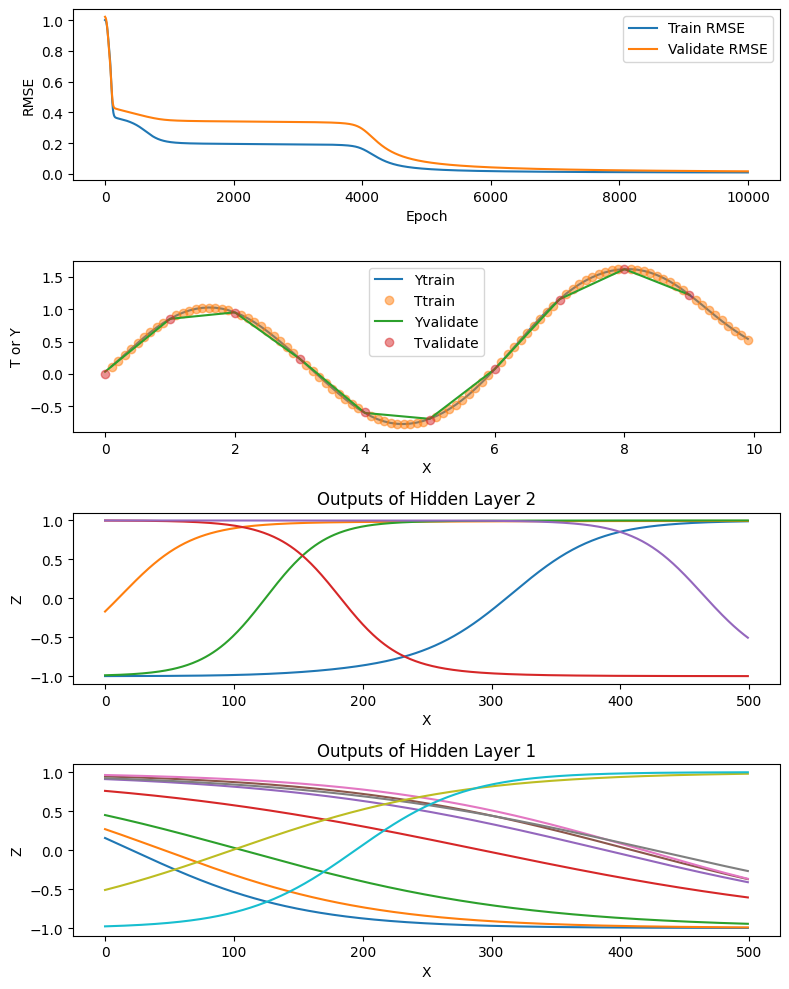

In [24]:
X = np.arange(0, 10, 0.1).reshape(-1, 1)
T = np.sin(X) + 0.01 * (X ** 2)

rows = np.arange(X.shape[0])
# Collect every 10th sample as the test set.
rows_validate = rows[::10]
# All remaining samples are in the train set.
rows_train = np.setdiff1d(rows, rows_validate)

Xtrain = X[rows_train, :]
Ttrain = T[rows_train, :]
Xvalidate = X[rows_validate, :]
Tvalidate = T[rows_validate, :]

n_inputs = X.shape[1]
n_hiddens_each_layer = [10, 5]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, n_hiddens_each_layer, n_outputs)
nnet.set_weights_for_testing()

n_epochs = 10000
n_epochs_per_plot = 200

fig = plt.figure(figsize=(8, 10))
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=n_epochs_per_plot, learning_rate=0.2)
    plot_data_and_model(nnet, Xtrain, Ttrain, Xvalidate, Tvalidate)
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)


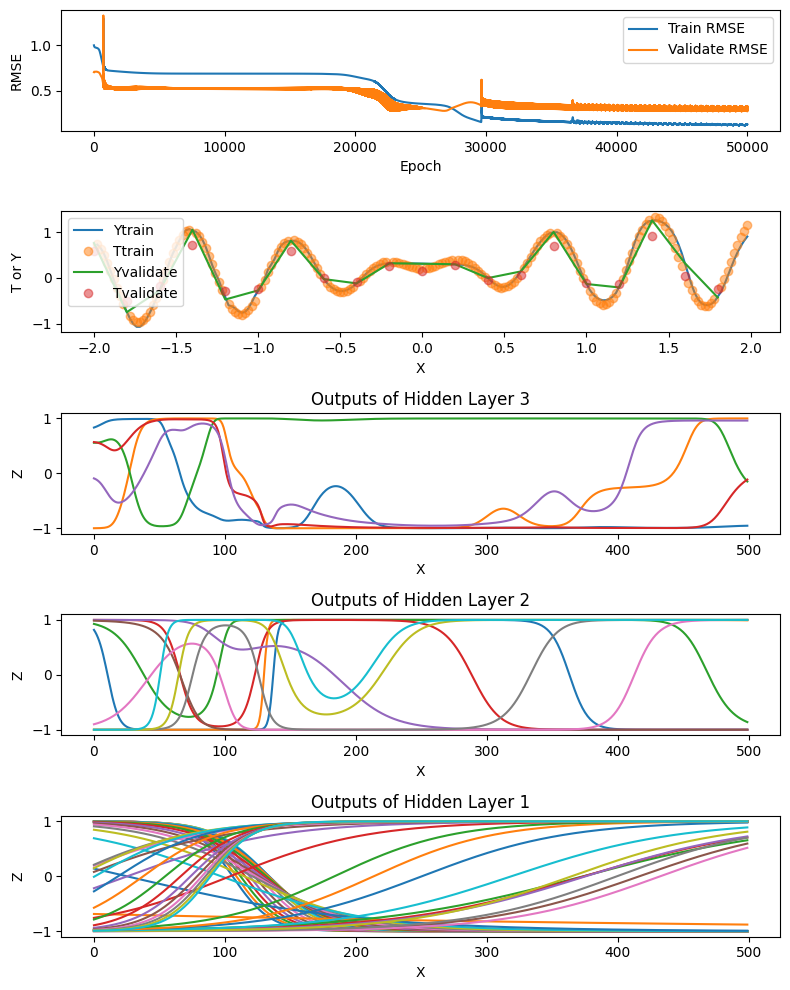

In [25]:
X = np.arange(-2, 2, 0.02).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10) + 0.1 * (X + 2)

rows = np.arange(X.shape[0])
rows_validate = rows[::10]
rows_train = np.setdiff1d(rows, rows_validate)

Xtrain = X[rows_train, :]
Ttrain = T[rows_train, :]
Xvalidate = X[rows_validate, :]
Tvalidate = T[rows_validate, :] * 0.7

n_inputs = X.shape[1]
n_hiddens_each_layer = [50, 10, 5]
n_outputs = T.shape[1]

nnet = NeuralNetwork(n_inputs, n_hiddens_each_layer, n_outputs)
nnet.set_weights_for_testing()

n_epochs = 50_000
n_epochs_per_plot = 500

fig = plt.figure(figsize=(8, 10))
for reps in range(n_epochs // n_epochs_per_plot):
    plt.clf()
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=n_epochs_per_plot, learning_rate=0.05)
    plot_data_and_model(nnet, Xtrain, Ttrain, Xvalidate, Tvalidate)
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(fig)
ipd.clear_output(wait=True)

Don't forget to test a neural network with no hidden layers, one hidden layer with a single unit, and other tests you are curious about.

## Application of `NeuralNetwork` class to some data related to the energy efficiency of buildings!

Download data from [Energy Efficiency at the UCI ML Repository](https://archive.ics.uci.edu/dataset/242/energy+efficiency). Read it into python using the `pandas.read_csv` function.  Assign the first 8 columns as inputs to `X` and the final two columns as target values to `T`.  Make sure `T` is two-dimensional with two columns.

In [27]:
!pip install openpyxl

In [28]:
import pandas

# Read the xlsx file as a pandas.DataFrame
data_df = pandas.read_excel('ENB2012_data.xlsx')
data = data_df.values

print(type(data), data.shape)

<class 'numpy.ndarray'> (768, 10)


From the information at the UCI site, we see these are the names of the input and target components.

In [29]:
Xnames = ['Relative Compactness',
    	  'Surface Area',
    	  'Wall Area',
          'Roof Area',
    	  'Overall Height',
          'Orientation',
    	  'Glazing Area',
    	  'Glazing Area Distribution']

Tnames = ['Heating Load',
    	  'Cooling Load']

In [30]:
Xnames, Tnames

(['Relative Compactness',
  'Surface Area',
  'Wall Area',
  'Roof Area',
  'Overall Height',
  'Orientation',
  'Glazing Area',
  'Glazing Area Distribution'],
 ['Heating Load', 'Cooling Load'])

In [31]:
X = data[:, :8]
T = data[:, 8:]
X.shape, T.shape

((768, 8), (768, 2))

In [32]:
rows = np.arange(X.shape[0])
np.random.shuffle(rows)
train_fraction = 0.8
ntrain = round(X.shape[0] * train_fraction)
Xtrain = X[rows[:ntrain], :]
Ttrain = T[rows[:ntrain], :]
Xvalidate = X[rows[ntrain:], :]
Tvalidate = T[rows[ntrain:], :]
Xtrain.shape, Ttrain.shape, Xvalidate.shape, Tvalidate.shape

((614, 8), (614, 2), (154, 8), (154, 2))

Now, write a function names `create_model` that accepts `n_hiddens_each_layer`, `n_epochs`, and `learning_rate` and that creates and trains a neural network with the correct number of inputs and outputs and the given value of `n_hiddens_each_layer`.  Add a few lines to apply the trained network with the `use` function on the `Xtrain` and `Xvalidate` data and calculates the RMSE for each. Have your function return the neural network and the two output arrays, `Ytrain` and `Yvalidate`.

In [33]:
def create_model(Xtrain, Ttrain, Xvalidate, Tvalidate, n_hiddens_each_layer, n_epochs, learning_rate):
    # Number of inputs and outputs based on the shape of the data
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]

    # Initialize the neural network
    nnet = NeuralNetwork(n_inputs, n_hiddens_each_layer, n_outputs)

    # Train the model
    nnet.train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs=n_epochs, learning_rate=learning_rate)

    # Get predictions for training and validation data
    Ytrain = nnet.use(Xtrain)
    Yvalidate = nnet.use(Xvalidate)

    # Return the trained model and predictions
    return nnet, Ytrain, Yvalidate



In [34]:
n_hiddens_each_layer = [10, 5]
n_epochs = 1000
learning_rate = 0.01

In [35]:
nnet, Ytrain, Yvalidate = create_model(Xtrain, Ttrain, Xvalidate, Tvalidate, n_hiddens_each_layer, n_epochs, learning_rate)

Starting with the following code to plot your results, add another four plots in two rows below these that plot the predicted values on the y axis and the target values on the x axis.  Add labels to all x and y axes that appear in this figure.

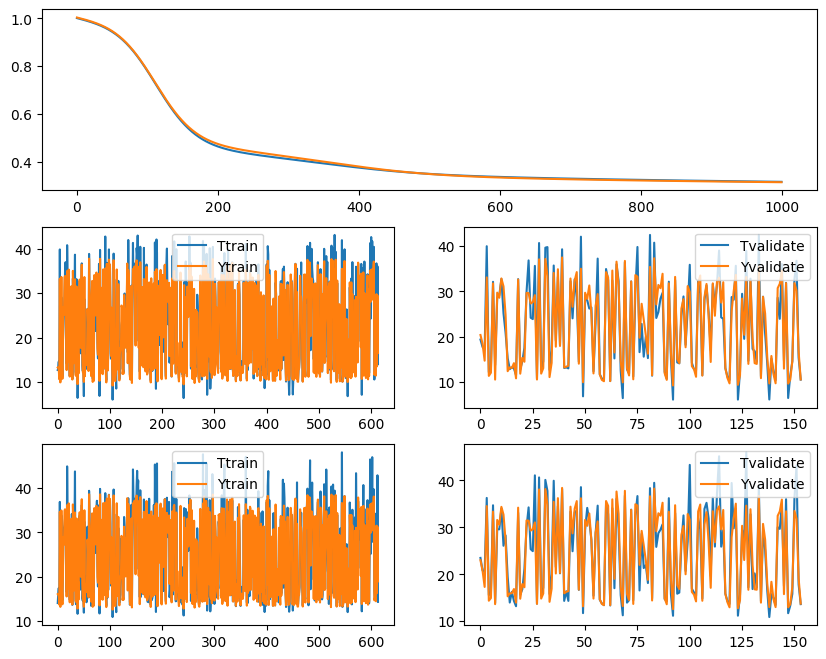

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(nnet.rmse_trace)

plt.subplot(3, 2, 3)
plt.plot(Ttrain[:, 0],  label='Ttrain')
plt.plot(Ytrain[:, 0],  label='Ytrain')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(Tvalidate[:, 0], label='Tvalidate')
plt.plot(Yvalidate[:, 0], label='Yvalidate')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(Ttrain[:, 1], label='Ttrain')
plt.plot(Ytrain[:, 1], label='Ytrain')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(Tvalidate[:, 1], label='Tvalidate')
plt.plot(Yvalidate[:, 1], label='Yvalidate')
plt.legend();

Run the previous two code cells several times with different values for `n_hiddens_each_layer`, `n_epochs`, and `learning_rate` until you have values that you think work pretty well.

In a markdown cell, write at least four sentences answering each of the following questions.

1. How is the training RMSE curve affected by the number of hidden layers and the number of units in each layer?
If the number of hidden layer decreases the RMSE curve increases. But if I increase the layer significantly it performs well on training data but bad on validation data. 

2.  How is the final training and validation RMSE affected by the number of epochs and learning rate?

Number of epoch lower the training RMSE. A smaller learning rate requires more epochs to converge but generally provides a smoother training curve. A larger learning rate can speed up convergence but at the risk of overshooting minima.

3. How much do the final training and validation RMSE values vary for different training runs that differ only in the intial random weights?
The variation is usually within a certain range, but outliers can occur, especially if the network gets stuck in poor local minima.

7. How well does your best model do in predicting heading and cooling load?  In other words, what does an RMSE of a particular value mean in relation to the target values?
Lower RMSE values indicating closer alignment with actual data and better performance. Comparing the RMSE to the target values' range helps assess whether the model's predictions are reliable and practically meaningful.


9. What was the hardest part of this assignment?  What is an estimate of the number of hours you spent on this assignment?
The hardest part was the probably find the good value for the parameters like the learning rate. I do not know how much hour I spent probably 7-8 hours.  

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.zip](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.zip) and unzip `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as `A2solution.ipynb`, and then save this notebook.  Check in your `A2solution.ipynb` notebook when you are ready.

In [38]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named A2solution.ipynb and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.


Testing this for 10 points:

n_inputs = 3
n_hiddens = [2, 1]
n_outputs = 2
n_samples = 5

X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
T = np.hstack((X, X*2))

nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
nnet.set_weights_for_testing()

# Set standardization variables so use() will run
nnet.X_means = 0
nnet.X_stds = 1
nnet.T_means = 0
nnet.T_stds = 1

Y = nnet.use(X)

Y_correct = np.array([[0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.]])

Weights set for testing by calling set_weights_for_testing()

#  and test result with    np.allclose(Y, Y_correct, 0.1)

----------------------------------------------------------------------
----  10/10 points. Y is correct value.
---------------------------------

In [40]:
n_inputs = 3
n_hiddens = [2, 1]
n_outputs = 2
n_samples = 5

X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
T = np.hstack((X, X*2))

nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
nnet.set_weights_for_testing()

# Set standardization variables so use() will run
nnet.X_means = 0
nnet.X_stds = 1
nnet.T_means = 0
nnet.T_stds = 1

Y = nnet.use(X)

Y_correct = np.array([[0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.],
    [0., 0.]])

np.allclose(Y, Y_correct, 0.1)

Weights set for testing by calling set_weights_for_testing()


True

In [41]:
n_inputs = 3
n_hiddens = [20, 20, 10, 10, 5]
n_samples = 100

X = np.arange(n_samples * n_inputs).reshape(n_samples, n_inputs) * 0.1
T = np.log(X + 0.1)
n_outputs = T.shape[1]

Xtrain = X[np.arange(0, n_samples, 2), :]
Ttrain = T[np.arange(0, n_samples, 2), :]
Xval = X[np.arange(1, n_samples, 2), :]
Tval = T[np.arange(1, n_samples, 2), :]

def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

nnet = NeuralNetwork(n_inputs, n_hiddens, n_outputs)
nnet.set_weights_for_testing()

nnet.train(Xtrain, Ttrain, Xval, Tval, 6000, 0.01)
Yval = nnet.use(Xval)
error = rmse(Yval, Tval)
print(f'RMSE {error:.4f}')

Weights set for testing by calling set_weights_for_testing()
RMSE 0.0481


In [44]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
T = np.array([[0], [1], [1], [0]])

n_hiddens_each_layer = [5, 10]
n_epochs = 1000
learning_rate = 0.1

nnet, Ytrain, Yvalidate = create_model(X, T, X, T,
                                       n_hiddens_each_layer, n_epochs, learning_rate)

Y_correct = np.array([[0], [1], [1], [0]])

np.allclose(Ytrain, Y_correct, 0.1) and np.allclose(Yvalidate, Y_correct, 0.1)

True

# Extra Credit (maximum of 2 points)

Which inputs does your trained neural network find to be most signficant?  

## Extra Credit (up to 1 point)

There are many ways to answer this.  For this extra credit, print the absolute values of the weights in the first hidden layer for all units in that layer.  The "all units" is the hard part.  Try just taking the mean of the absolute values of the weights for each input across all units.  Do the results make sense to you?

## Extra Credit (up to 1 point)

Try using a `matplotlib.pyplot` call like

```
plt.imshow(np.abs(nnet.Ws[0]), interpolation='nearest')
plt.colorbar()
```

to see if you can visually see patterns in the weight magnitudes.  Describe what you see.